# **Practice 2**

# Directory mount

In [1]:
# Run this codeblock to mount your Google Drive in Google Colab.
# from google.colab import drive
# drive.mount("/content/drive/")

In [2]:
from pathlib import Path
import numpy as np
import cv2
import time
import matplotlib.pylab as plt
from scipy.ndimage import zoom, map_coordinates

ROOT = "./"  # TODO: set your root directory here
# ROOT = '/content/drive/MyDrive/실습2' # example for Google Drive

ROOT = Path(ROOT)
# Check if the root directory exists
if not ROOT.exists():
    print(f"Root directory {ROOT} does not exist. Please check the path.")

# Load image

Load `memi.jpg` as grayscale image

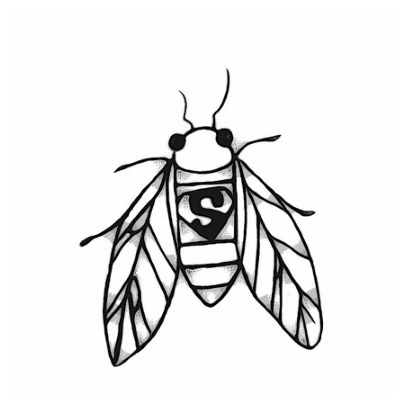

In [3]:
memi = cv2.imread(ROOT / "memi.jpg", cv2.IMREAD_GRAYSCALE)
memi = np.array(memi).astype(np.float32) / 255.0

plt.figure(figsize=(5, 5))
plt.imshow(memi, cmap="gray")
plt.axis("off")
plt.show()

# Define affine transform function

The function `image_map_coordinates` applies an affine transformation to a given image using a coordinate-mapping approach. The transformation is defined by an input transform_matrix, which can represent operations such as rotation, scaling, or shearing.

Rather than applying the transformation directly to the image pixels, this function performs inverse mapping: it computes, for each pixel in the output image, where it originally came from in the input image.

In [15]:
def image_map_coordinates(image, transform_matrix):
    # TODO: Apply the transformation matrix to the image using map_coordinates
    h, w = image.shape
    center = np.array([h//2, w//2])
    coord_x, coord_y = np.meshgrid(np.arange(w), np.arange(h))
    coords = np.stack([coord_y.ravel(), coord_x.ravel()])
    coords_centered = coords - center[:, np.newaxis]

    inv_transform = np.linalg.inv(transform_matrix)
    src_coords = inv_transform @ coords_centered + center[:, np.newaxis]

    transformed_flat = map_coordinates(
        image, src_coords, order=1, cval=1
    )
    transformed = transformed_flat.reshape(h, w)
    return transformed

## Rotation

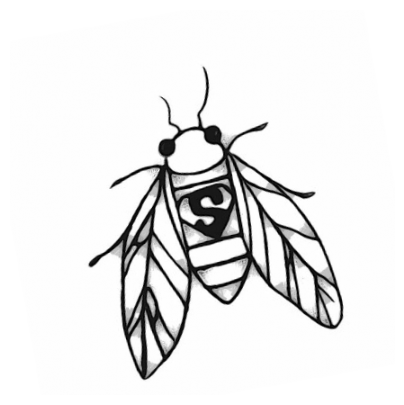

In [17]:
rot_angle = 10
ang_rad = np.deg2rad(rot_angle)
transform_matrix = np.array([[np.cos(ang_rad), -np.sin(ang_rad)],[np.sin(ang_rad), np.cos(ang_rad)]])

memi_rotated = image_map_coordinates(memi, transform_matrix)

plt.figure(figsize=(5, 5))
plt.imshow(memi_rotated, cmap="gray")
plt.axis("off")
plt.show()

## Shear
Using the shear matrix $\left(\begin{matrix} 1 & 0.2 \\ 0 & 1\end{matrix}\right)$

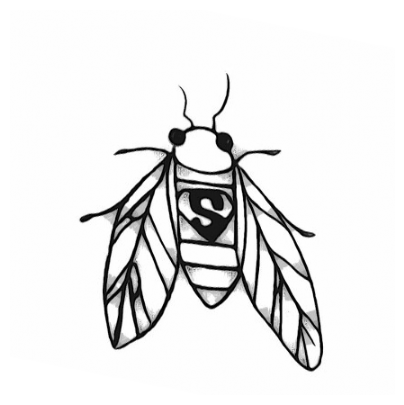

In [20]:
sheer_transform_matrix = np.array([[1, 0.2], [0, 1]])# TODO: create a transformation matrix for sheering

memi_rotated = image_map_coordinates(memi, sheer_transform_matrix)

plt.figure(figsize=(5, 5))
plt.imshow(memi_rotated, cmap="gray")
plt.axis("off")
plt.show()

## Interpolation

Compare sinc, linear, and quadratic interpolation

In [21]:
def sinc_interpolation(image, scale):
    h, w = image.shape
    new_h, new_w = int(h * scale), int(w * scale)

    image_k = np.fft.fftshift(np.fft.fft2(image))

    new_image_k = np.zeros((new_h, new_w), dtype=np.complex64)

    if scale >= 1:
        h_start = (new_h - h) // 2
        w_start = (new_w - w) // 2
        new_image_k[h_start : h_start + h, w_start : w_start + w] = image_k * (scale**2)
    else:
        h_crop = (h - new_h) // 2
        w_crop = (w - new_w) // 2
        new_image_k = image_k[h_crop : h_crop + new_h, w_crop : w_crop + new_w] * (scale**2)

    resized_image = np.fft.ifft2(np.fft.ifftshift(new_image_k))
    resized_image = np.real(resized_image)

    return resized_image


def linear_interpolation(image, scale):
    return zoom(image, scale, order=1)


def quadratic_interpolation(image, scale):
    return zoom(image, scale, order=3)

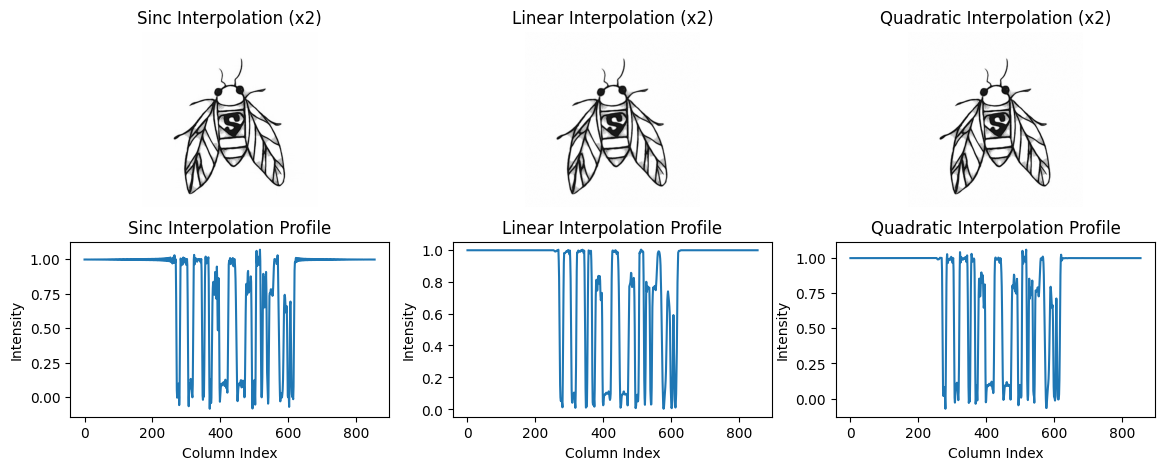

In [22]:
memi_x2_sinc = sinc_interpolation(memi, 2)
memi_x2_linear = linear_interpolation(memi, 2)
memi_x2_quadratic = quadratic_interpolation(memi, 2)
plt.figure(figsize=(14, 5))
plt.subplot(2, 3, 1)
plt.imshow(memi_x2_sinc, cmap="gray", vmin=0, vmax=1)
plt.title("Sinc Interpolation (x2)")
plt.axis("off")
plt.subplot(2, 3, 2)
plt.imshow(memi_x2_linear, cmap="gray", vmin=0, vmax=1)
plt.title("Linear Interpolation (x2)")
plt.axis("off")
plt.subplot(2, 3, 3)
plt.imshow(memi_x2_quadratic, cmap="gray", vmin=0, vmax=1)
plt.title("Quadratic Interpolation (x2)")
plt.axis("off")
plt.subplot(2, 3, 4)
plt.plot(memi_x2_sinc[memi_x2_sinc.shape[0] // 2, :], label="Sinc Interpolation")
plt.title("Sinc Interpolation Profile")
plt.xlabel("Column Index")
plt.ylabel("Intensity")
plt.subplot(2, 3, 5)
plt.plot(memi_x2_linear[memi_x2_linear.shape[0] // 2, :], label="Linear Interpolation")
plt.title("Linear Interpolation Profile")
plt.xlabel("Column Index")
plt.ylabel("Intensity")
plt.subplot(2, 3, 6)
plt.plot(memi_x2_quadratic[memi_x2_quadratic.shape[0] // 2, :], label="Quadratic Interpolation")
plt.title("Quadratic Interpolation Profile")
plt.xlabel("Column Index")
plt.ylabel("Intensity")
plt.show()

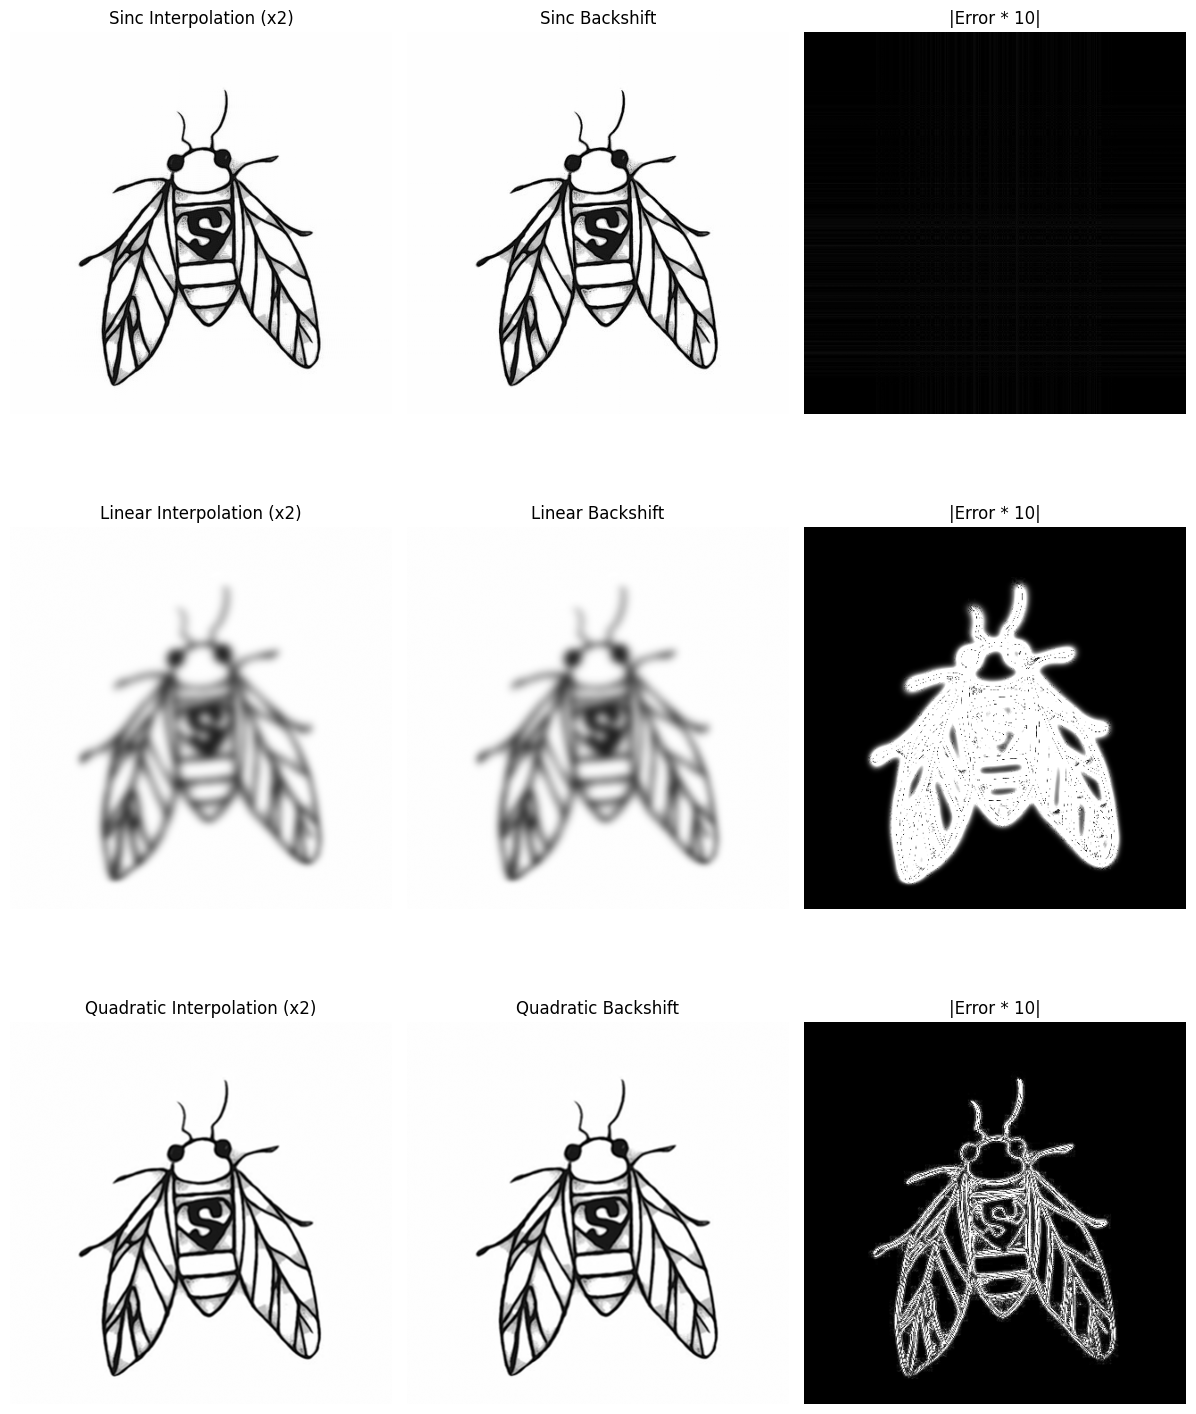

In [23]:
iterations = 100
memi_sinc = memi.copy()
memi_linear = memi.copy()
memi_quadratic = memi.copy()
for i in range(iterations):
    memi_x2_sinc = sinc_interpolation(memi_sinc, 2)
    memi_sinc = sinc_interpolation(memi_x2_sinc, 0.5)
    memi_x2_linear = linear_interpolation(memi_linear, 2)
    memi_linear = linear_interpolation(memi_x2_linear, 0.5)
    memi_x2_quadratic = quadratic_interpolation(memi_quadratic, 2)
    memi_quadratic = quadratic_interpolation(memi_x2_quadratic, 0.5)

plt.figure(figsize=(20, 15))
plt.subplot(3, 5, 3)
plt.imshow(memi_x2_sinc, cmap="gray", vmin=0, vmax=1)
plt.title("Sinc Interpolation (x2)")
plt.axis("off")
plt.subplot(3, 5, 4)
plt.imshow(memi_sinc, cmap="gray", vmin=0, vmax=1)
plt.title("Sinc Backshift")
plt.axis("off")
plt.subplot(3, 5, 5)
plt.imshow(abs(memi - memi_sinc), cmap="gray", vmin=0.0, vmax=0.1)
plt.title("|Error * 10|")
plt.axis("off")
plt.subplot(3, 5, 8)
plt.imshow(memi_x2_linear, cmap="gray", vmin=0, vmax=1)
plt.title("Linear Interpolation (x2)")
plt.axis("off")
plt.subplot(3, 5, 9)
plt.imshow(memi_linear, cmap="gray", vmin=0, vmax=1)
plt.title("Linear Backshift")
plt.axis("off")
plt.subplot(3, 5, 10)
plt.imshow(abs(memi - memi_linear), cmap="gray", vmin=0.0, vmax=0.1)
plt.title("|Error * 10|")
plt.axis("off")
plt.subplot(3, 5, 13)
plt.imshow(memi_x2_quadratic, cmap="gray", vmin=0, vmax=1)
plt.title("Quadratic Interpolation (x2)")
plt.axis("off")
plt.subplot(3, 5, 14)
plt.imshow(memi_quadratic, cmap="gray", vmin=0, vmax=1)
plt.title("Quadratic Backshift")
plt.axis("off")
plt.subplot(3, 5, 15)
plt.imshow(abs(memi - memi_quadratic), cmap="gray", vmin=0.0, vmax=0.1)
plt.title("|Error * 10|")
plt.axis("off")
plt.tight_layout()


plt.show()

## Exercises

Applying rotation with linear and quadratic interpolation

In [25]:
def image_map_coordinates_linear(image, transform_matrix):
    h, w = image.shape
    center = np.array([h / 2, w / 2])

    rotated = np.zeros_like(image)

    coords_x, coords_y = np.meshgrid(np.arange(w), np.arange(h))
    coords = np.stack([coords_y.ravel(), coords_x.ravel()])

    coords_centered = coords - center[:, np.newaxis]
    inv_rot = np.linalg.inv(transform_matrix)
    src_coords = inv_rot @ coords_centered + center[:, np.newaxis]

    rotated_flat = map_coordinates(
        image, src_coords, order=1, mode="constant", cval=1.0
    )
    rotated = rotated_flat.reshape(h, w)

    return rotated


def image_map_coordinates_quadratic(image, transform_matrix):
    h, w = image.shape
    center = np.array([h / 2, w / 2])

    rotated = np.zeros_like(image)

    coords_x, coords_y = np.meshgrid(np.arange(w), np.arange(h))
    coords = np.stack([coords_y.ravel(), coords_x.ravel()])

    coords_centered = coords - center[:, np.newaxis]
    inv_rot = np.linalg.inv(transform_matrix)
    src_coords = inv_rot @ coords_centered + center[:, np.newaxis]

    rotated_flat = map_coordinates(
        image, src_coords, order=3, mode="constant", cval=1.0
    )
    rotated = rotated_flat.reshape(h, w)

    return rotated

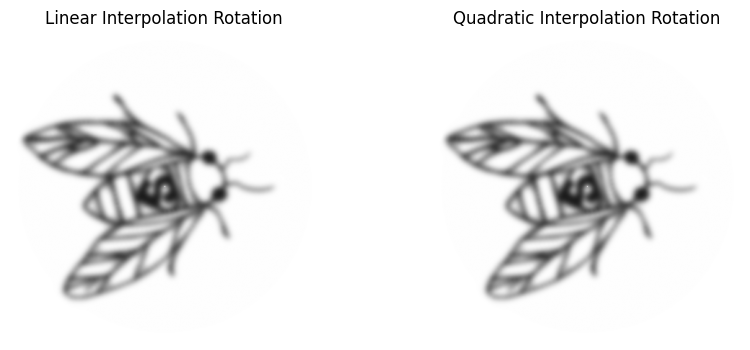

In [27]:
from IPython.display import clear_output, display

iterations = 100
rot_angle = 10
angle_rad = np.deg2rad(rot_angle)
cos_a = np.cos(angle_rad)
sin_a = np.sin(angle_rad)
transform_matrix = np.array([[cos_a, -sin_a], [sin_a, cos_a]])

memi_rot_linear = memi.copy()
memi_rot_quadratic = memi.copy()

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
im1 = axs[0].imshow(memi_rot_linear, cmap="gray", vmin=0, vmax=1)
axs[0].set_title("Linear Interpolation Rotation")
axs[0].axis("off")

im2 = axs[1].imshow(memi_rot_quadratic, cmap="gray", vmin=0, vmax=1)
axs[1].set_title("Quadratic Interpolation Rotation")
axs[1].axis("off")

for i in range(iterations):
    # TODO: Apply linear interpolation rotation and quadratic interpolation rotation
    memi_rot_linear = image_map_coordinates_linear(memi_rot_linear, transform_matrix)
    memi_rot_quadratic = image_map_coordinates_linear(memi_rot_quadratic, transform_matrix)
    im1.set_data(memi_rot_linear)
    im2.set_data(memi_rot_quadratic)

    clear_output(wait=True)
    display(fig)
    plt.pause(0.2)

plt.close(fig)

## Convolution


Load `bird.jpg` as grayscale image

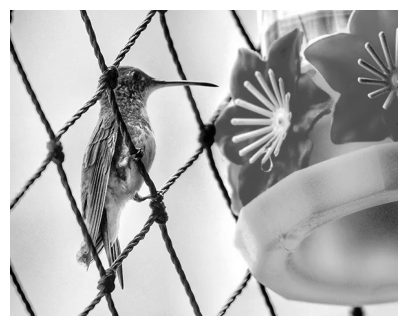

In [28]:
img = cv2.imread(ROOT / "bird.jpg", 0)
img = np.array(img)

height = img.shape[0]
width = img.shape[1]

img_res = np.zeros([height, width])
img_res.fill(1)

plt.figure(figsize=(5, 5))
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show()

Define convolution kernels

In [29]:
blur_3x3 = np.ones([3, 3])

blur_7x7 = np.ones([7,7])# TODO: create a 7x7 averaging filter

Laplacian = np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]]) # TODO: create a Laplacian filter

SobelY = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])# TODO: create a Sobel filter for Y direction

Convolution using `for`-loops

In [34]:
def my_convolution(image, kernel):
    # TODO: Implement convolution operation using for-loops
    h, w = image.shape
    m, n = kernel.shape

    pad_height = (h - 1) // 2
    pad_width = (w - 1) // 2

    image_padded = np.pad(image, (pad_height, pad_width), mode='constant')
    image_res = np.zeros((h, w))

    for x in range(image_res.shape[1]):
        for y in range(image_res.shape[0]):
            image_res[y, x] = np.sum(
                image_padded[y:y+m, x:x+n]*kernel
            )
    return image_res

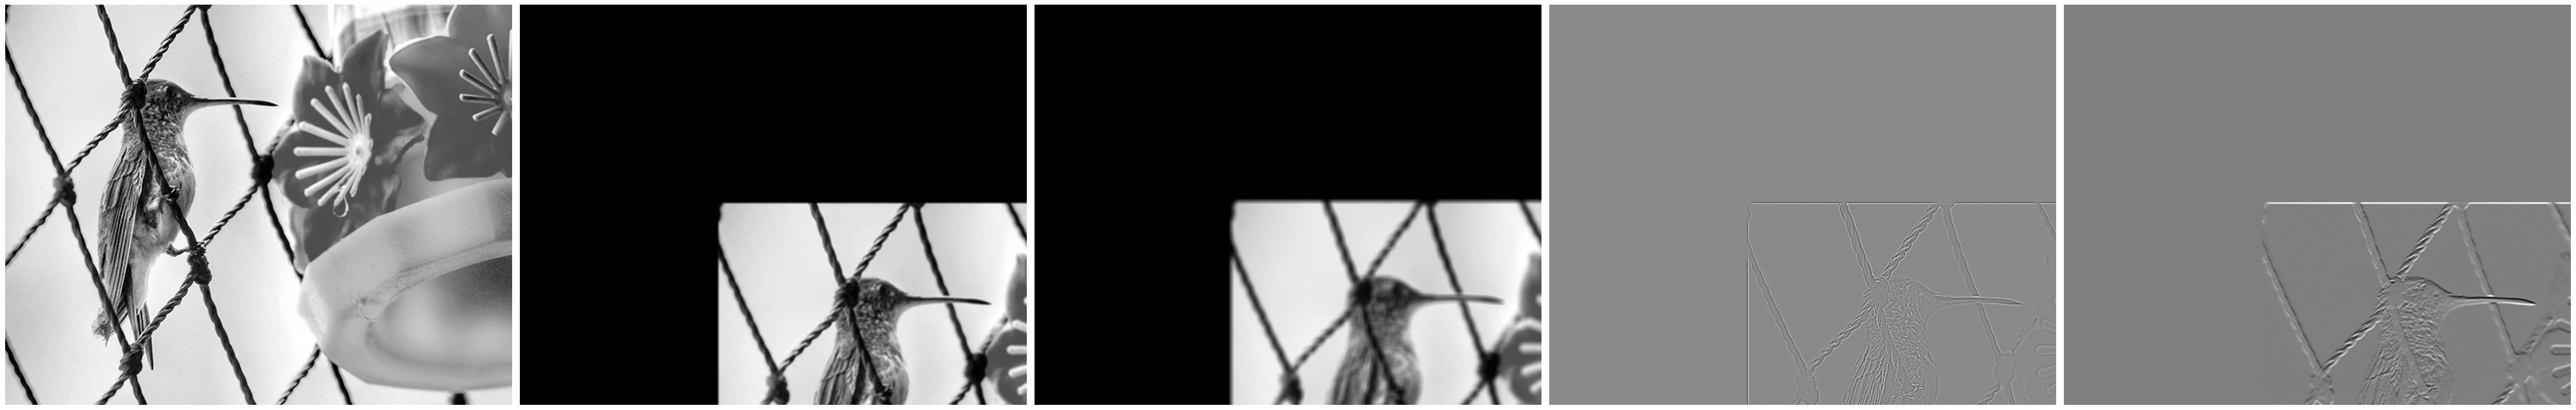

In [36]:
plt.figure(figsize=(50, 10))
plt.subplot(1, 5, 1)
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.subplot(1, 5, 2)
plt.imshow(my_convolution(img, blur_3x3), cmap="gray")
plt.axis("off")
plt.subplot(1, 5, 3)
plt.imshow(my_convolution(img, blur_7x7), cmap="gray")
plt.axis("off")
plt.subplot(1, 5, 4)
plt.imshow(my_convolution(img, Laplacian), cmap="gray")
plt.axis("off")
plt.subplot(1, 5, 5)
plt.imshow(my_convolution(img, SobelY), cmap="gray")
plt.axis("off")
plt.tight_layout()
plt.show()

However torch, which is the famous library for deep learning, provides a powerful tools for convolution

For example, let's use `conv2d` function.

In [15]:
import torch
from torch.nn.functional import conv2d

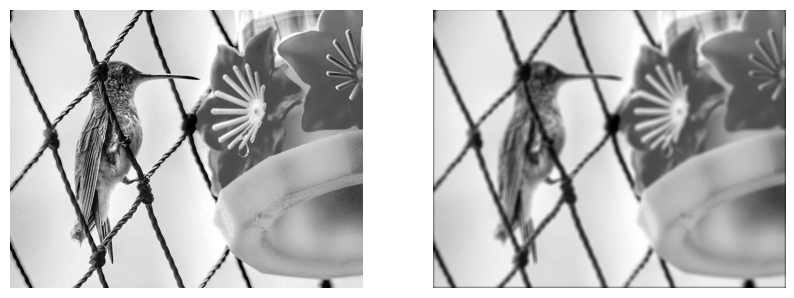

In [17]:
kernel = blur_7x7

img_torch = torch.from_numpy(img).float().unsqueeze(0).unsqueeze(0)
kernel_torch = torch.from_numpy(kernel).float().unsqueeze(0).unsqueeze(0)
img_res_torch = conv2d(img_torch, kernel_torch, padding=[ int((kernel.shape[0] - 1) / 2), int((kernel.shape[1] - 1) / 2)])
img_res_torch = img_res_torch.squeeze().numpy()
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(img_res_torch, cmap="gray")
plt.axis("off")
plt.show()

Let's compare the computation times

In [ ]:
# convolution with for loop time
start_time = time.time()
# TODO: apply convolution using for loop
end_time = time.time()
for_loop_time = end_time - start_time
print(f"Time taken for convolution with for loop: {for_loop_time:.4f} seconds")

# convolution with torch time
start_time = time.time()
# TODO: apply convolution using torch
end_time = time.time()
torch_time = end_time - start_time
print(f"Time taken for convolution with torch: {torch_time:.4f} seconds")

print(f"Torch is {for_loop_time / torch_time:.2f} times faster than for loop.")

Time taken for convolution with for loop: 0.7350 seconds
Time taken for convolution with torch: 0.0010 seconds
Torch is 733.83 times faster than for loop.


This resuls will much more faster if you use GPU.